In [1]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from keras.layers import *
from keras.models import *
from keras.datasets import mnist
from keras.optimizers import RMSprop
import keras.backend as K

Using TensorFlow backend.


In [2]:
import tensorflow as tf

In [5]:
#Hyperparameters
batch_size = 16
iterations = 10000

#Loss tracking
d_loss = []
g_loss = []
gp_loss = []

N = 16

def generate_rect(x, y, w, h):
  data = np.zeros((N,N))
  data[x:x+w+1, y:y+h+1] = 1
  data[x+1:x+w, y+1:y+h] = 0
  #data = np.reshape(data, (N*N))
  return data

'''FILLED RECTANGLES'''
def create_filled_rectangle(posX, posY, width, height):
    data = np.zeros((N, N))
    data[posX : posX + width + 1, posY : posY + height + 1] = 1
    return data

'''THICK BORDER RECTANGLES'''
def create_thick_rectangles(posX, posY, width, height, thickness_x, thickness_y):
    empyt_rect_width = width - 2*thickness_x
    empyt_rect_height = height - 2*thickness_y
        
    data = np.zeros((N,N))
    data[posX:posX+width+1, posY:posY+height+1] = 1
    
    if empyt_rect_width > 0 and empyt_rect_height > 0:
        data[posX+thickness_x: posX+thickness_x+empyt_rect_width+1, posY+thickness_y: posY+thickness_y+empyt_rect_height+1] = 0
    else:
        return None

    return data
 
x_train = []

def create_thick_border_rectangle_data():
    for x in range(0, N-2):
        for y in range(0, N-2):
            for w in range(2,N):
                for h in range(2,N):
                    if x+w<N and y+h<N:
                        data = create_thick_rectangles(x,y,w,h, 2, 2)
                        if data is not None:
                            x_train.append(data)

def create_empty_rectangle_data():
    for x in range(0, N-2):
        for y in range(0, N-2):
            for w in range(2,N):
                for h in range(2,N):
                    if x+w<N and y+h<N:
                        x_train.append(generate_rect(x,y,w,h))

create_thick_border_rectangle_data()

x_train = np.array(x_train).astype('int32')
#x_train = np.reshape(x_train, (np.shape(x_train)[0], 8, 8, 1))
print(np.shape(x_train))

train_size, x_dims, y_dims = x_train.shape
z_dims = np.amax(x_train) + 1 # Number of different title types
print(z_dims)
train_images_onehot = np.eye(z_dims, dtype='uint8')[x_train]
print(train_images_onehot.shape) # (train_size, x_dims, y_dims, z_dims)

x_train = np.zeros((train_size, 16, 16, z_dims))
print(x_train.shape)

# TODO: Change empty space encoding here if different
x_train[:, :, :, 1] = 0.0  # Fill with empty space 

x_train[:train_size, :x_dims, :y_dims, :] = train_images_onehot
print(x_train.shape)

(4356, 16, 16)
2
(4356, 16, 16, 2)
(4356, 16, 16, 2)
(4356, 16, 16, 2)


In [6]:
def r1_gradient_penalty(y_true, y_pred, samples):
    #Get gradients of pixel values (first layer)
    gradients = K.gradients(y_pred, samples)[0]
    
    #Get norm squared: ||grad||^2
    gradients_sqr = K.square(gradients)
    gradient_norm = K.sum(gradients_sqr, axis = [1, 2, 3])
    
    #Return average over batch
    return K.mean(gradient_norm)

In [7]:
def AdaIN(x):
    #Normalize x[0]
    mean = K.mean(x[0], axis = [0, 1], keepdims = True)
    std = K.std(x[0], axis = [0, 1], keepdims = True) + 1e-7
    y = (x[0] - mean) / std
    
    #Reshape gamma and beta
    pool_shape = [-1, 1, 1, y.shape[-1]]
    g = K.reshape(x[1], pool_shape)
    b = K.reshape(x[2], pool_shape)
    
    #Multiply by x[1] (GAMMA) and add x[2] (BETA)
    return y * g + b

In [8]:
def g_block(input_tensor, latent_vector, filters):
    gamma = Dense(filters, bias_initializer = 'ones')(latent_vector)
    beta = Dense(filters)(latent_vector)
    
    out = UpSampling2D()(input_tensor)
    out = Conv2D(filters, 3, padding = 'same')(out)
    out = Lambda(AdaIN)([out, gamma, beta])
    out = Activation('relu')(out)
    
    return out

In [9]:
def d_block(input_tensor, filters):
    out = Conv2D(filters, 3, padding = 'same')(input_tensor)
    out = LeakyReLU(0.2)(out)
    out = AveragePooling2D()(out)
    return out

In [10]:
#Latent input
latent_input = Input([16])

#Map latent input
latent = Dense(64, activation = 'relu')(latent_input)
latent = Dense(64, activation = 'relu')(latent)
latent = Dense(64, activation = 'relu')(latent)

#Reshape to 4x4x32
x = Dense(4*4*32, activation = 'relu')(latent_input)
x = Reshape([4, 4, 32])(x)

#Size: 4x4x32
x = g_block(x, latent, 16)

#Size: 8x8x16
x = g_block(x, latent, 8)


#Size: 16x16x8, make RGB with values between 0 and 1
image_output = Conv2D(2, 1, padding = 'same', activation = 'sigmoid')(x)

#Make Model
generator = Model(inputs = latent_input, outputs = image_output)

#Model Summary
generator.summary()





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          8704        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           1088        input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 4, 4, 32)     0           dense_4[0][0]                    
__________________________________________________________________________________________________
dense_

In [11]:
#Image input
image_input = Input([16, 16, 2])

#Size: 64x64x3
x = d_block(image_input, 8)

#Size: 32x32x8
x = d_block(x, 16)

#Size: 4x4x16
x = Conv2D(32, 2, padding = 'same')(x)
x = LeakyReLU(0.2)(x)
x = Flatten()(x)

#1-dimensional Neural Network
class_output = Dense(1)(x)

#Make Model
discriminator = Model(inputs = image_input, outputs = class_output)

#Model summary
discriminator.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16, 16, 2)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 8)         152       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 8)         0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 16)          1168      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 16)          0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 4, 4, 16)          0         
_________

In [12]:
#Build network to train the discriminator.
#Discriminator will train, but Generator won't train.
for layer in discriminator.layers:
    layer.trainable = True
    
for layer in generator.layers:
    layer.trainable = False
    
    
    
#Get real image
real_image = Input([16, 16, 2])

#Discriminator classifies
validity_real = discriminator(real_image)



#Get latent input
latent_input = Input([16])

#Generate an image
fake_image = generator(latent_input)

#Discriminator classifies
validity_fake = discriminator(fake_image)


#Create Gradient Penalty Loss with Real Samples
partial_gp = partial(r1_gradient_penalty, samples = real_image)

#Create and compile the model
DiscriminatorModel = Model(inputs = [real_image, latent_input], outputs = [validity_real, validity_fake, validity_real])

DiscriminatorModel.compile(optimizer = RMSprop(lr = 0.0002),
                           loss = ['mean_squared_error', 'mean_squared_error', partial_gp],
                           loss_weights = [1, 1, 10])

C:\Users\User\anaconda3\envs\gputest\lib\site-packages\keras\engine\topology.py:1541: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'model_2/dense_9/BiasAdd:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'model_2_1/dense_9/BiasAdd:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'model_2/dense_9/BiasAdd:0' shape=(?, 1) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [13]:
#Build network to train the generator.
#Discriminator won't train, but Generator will train.
for layer in discriminator.layers:
    layer.trainable = False
    
for layer in generator.layers:
    layer.trainable = True

#Get latent input
latent_input = Input([16])

#Generate an image
fake_image = generator(latent_input)

#Discriminator classifies
validity = discriminator(fake_image)

#Create and compile the model
GeneratorModel = Model(inputs = latent_input, outputs = validity)

GeneratorModel.compile(optimizer = RMSprop(lr = 0.0002), loss = 'mean_squared_error')

In [14]:
#Train the models in a loop
for i in range(iterations):
    
    print('\rIteration ' + str(i), end = '')
    
    #Get labels
    real_labels = np.ones([batch_size, 1])
    fake_labels = np.zeros([batch_size, 1])
    dummy_labels = np.ones([batch_size, 1])
    
    #Train discriminator
    #Get images and latent vectors
    image_indices = np.random.randint(0, x_train.shape[0] - 1, [batch_size])
    real_images = x_train[image_indices]
    latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 16])
    
    #Train
    loss = DiscriminatorModel.train_on_batch([real_images, latent_vectors], [real_labels, fake_labels, dummy_labels])
    d_loss.append(loss[1]/2 + loss[2]/2)
    gp_loss.append(loss[3])
    
    #Train generator
    #Get latent vectors
    latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 16])
    
    #Train using opposite labels
    loss = GeneratorModel.train_on_batch(latent_vectors, real_labels)
    g_loss.append(loss)

Iteration 0

C:\Users\User\anaconda3\envs\gputest\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'










Iteration 14

C:\Users\User\anaconda3\envs\gputest\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Iteration 9999

C:\Users\User\anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


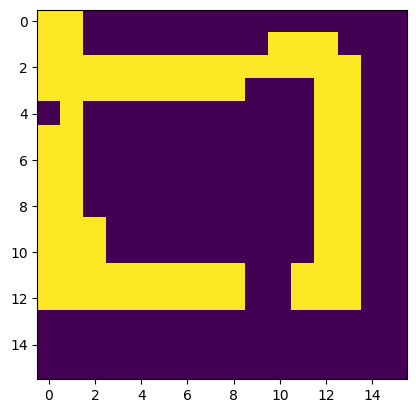

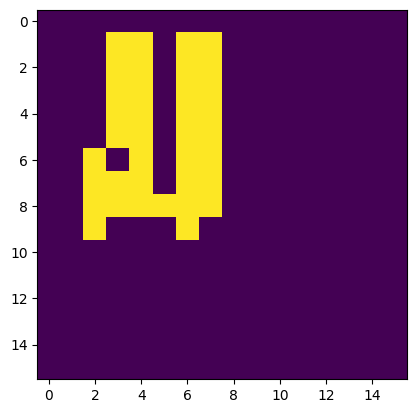

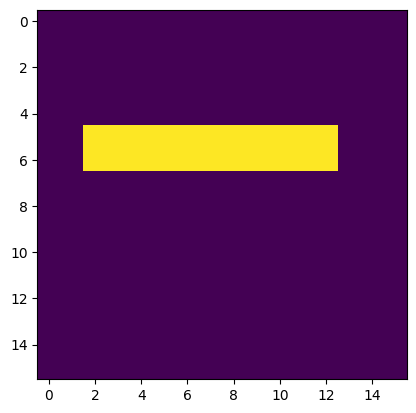

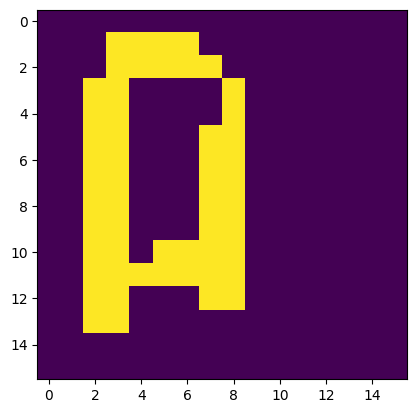

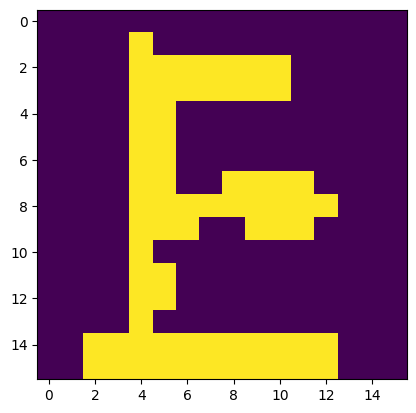

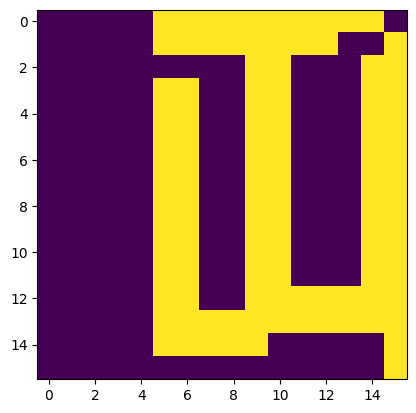

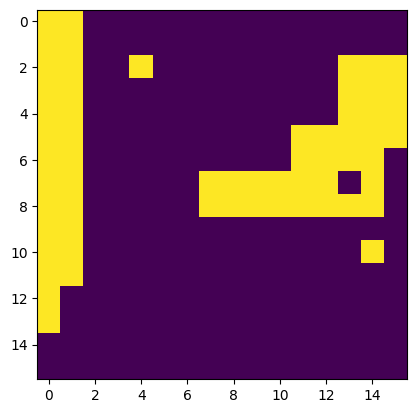

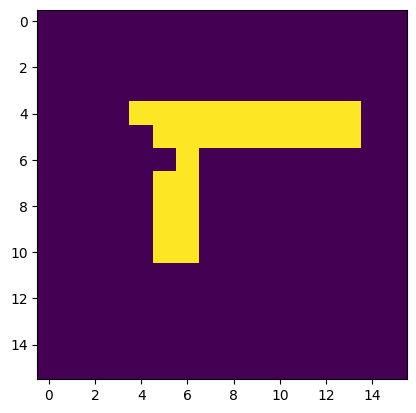

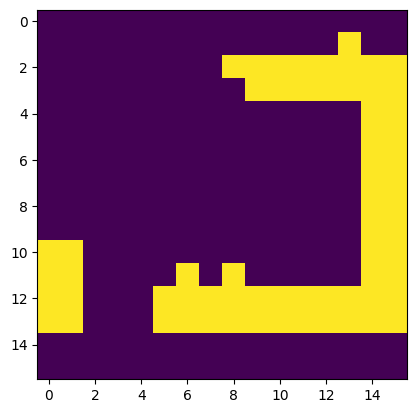

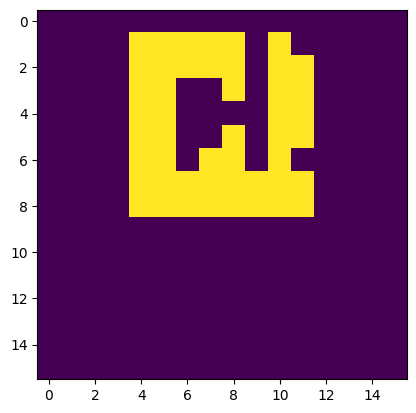

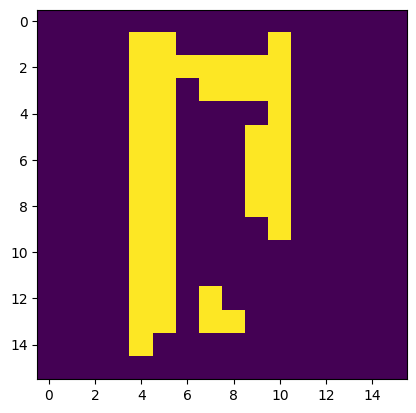

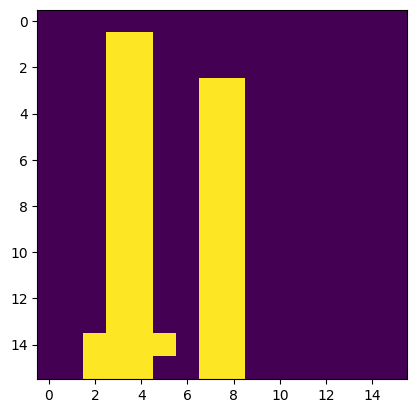

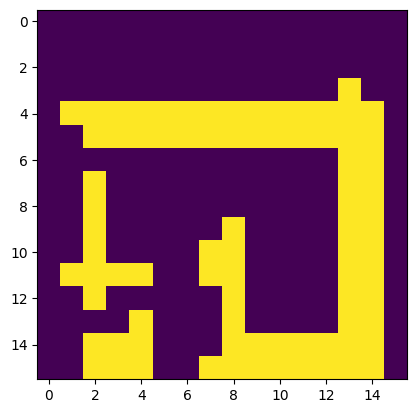

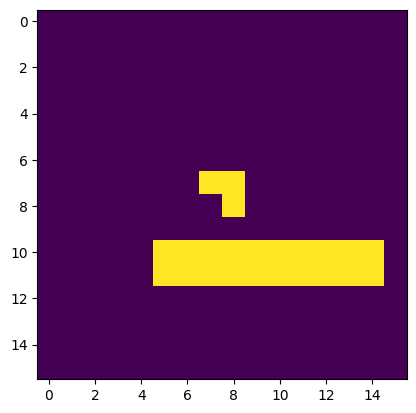

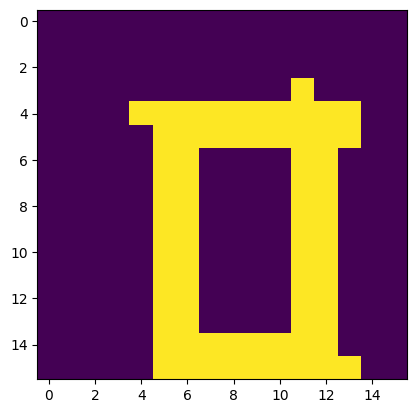

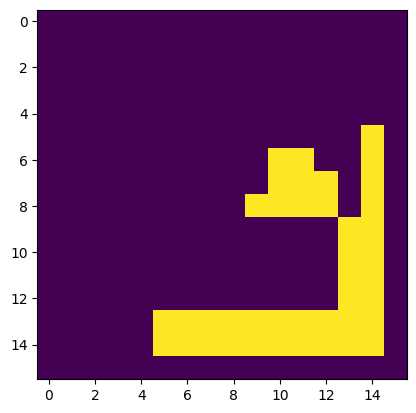

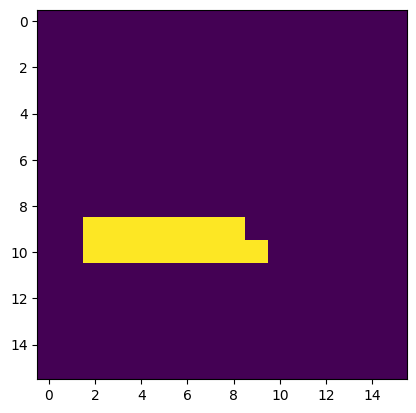

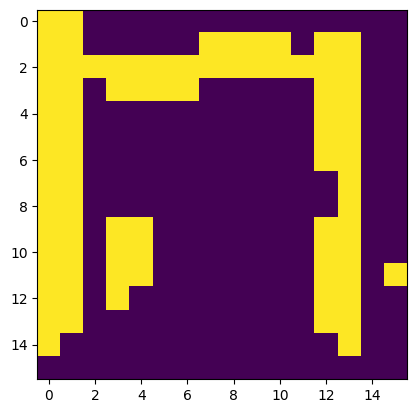

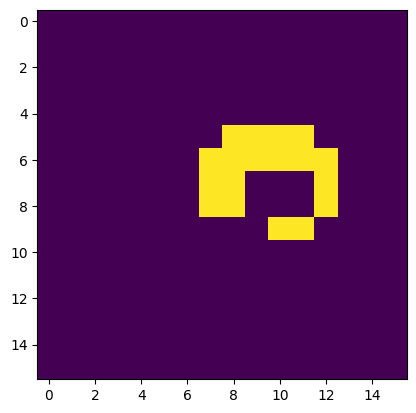

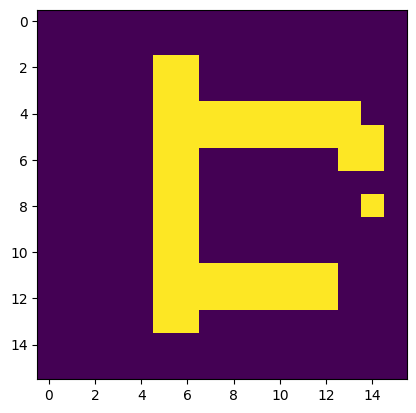

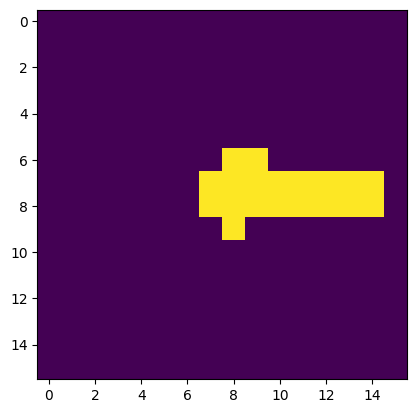

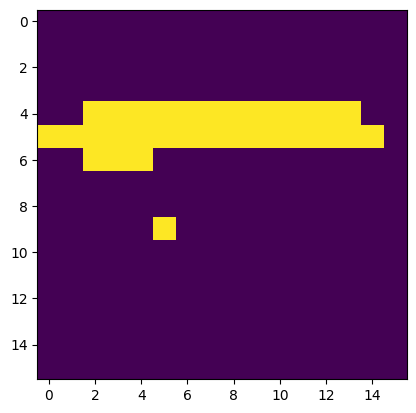

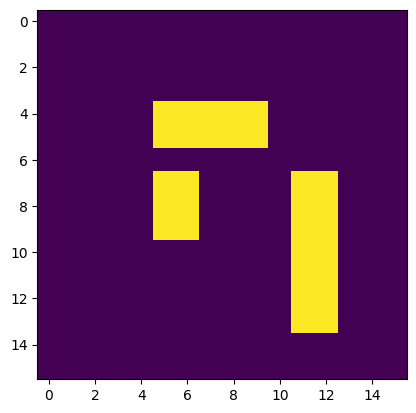

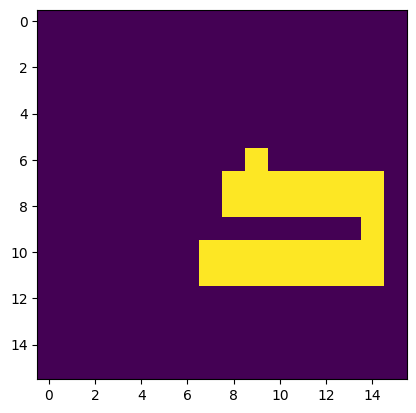

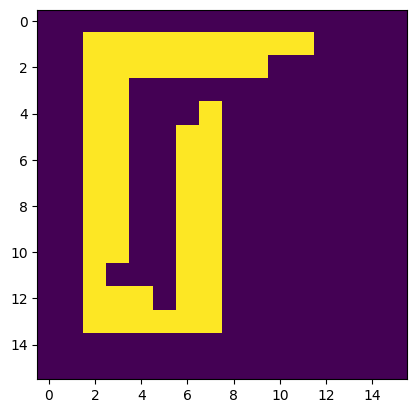

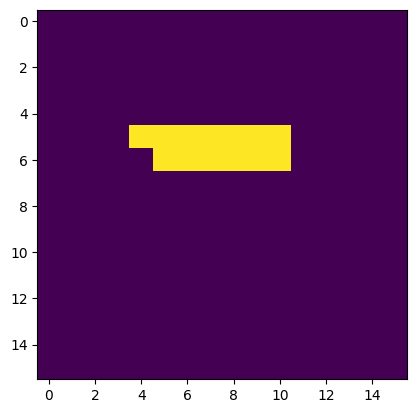

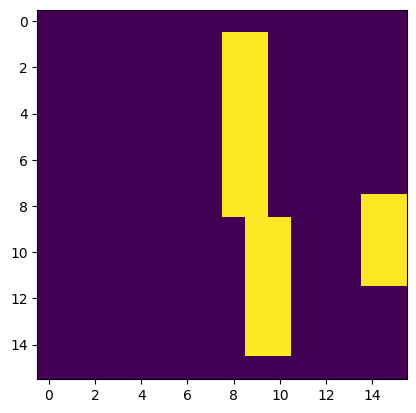

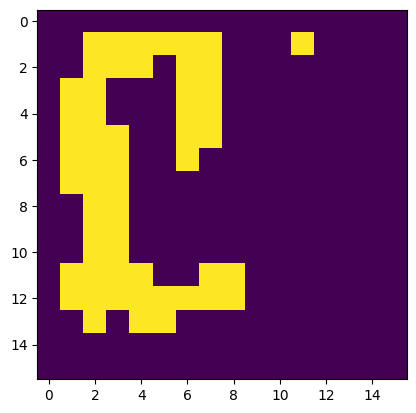

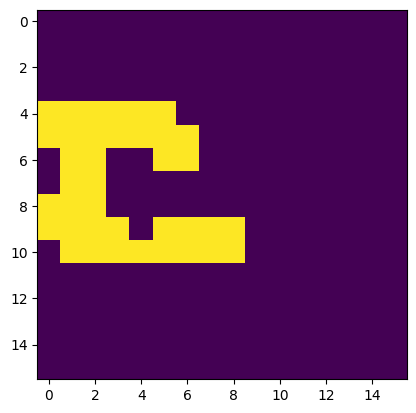

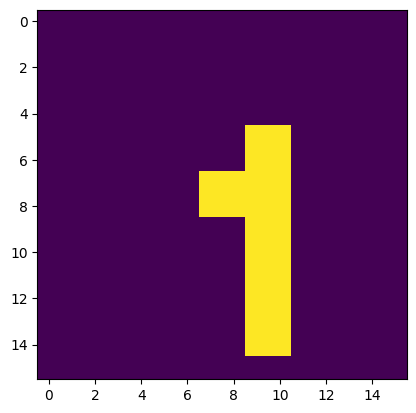

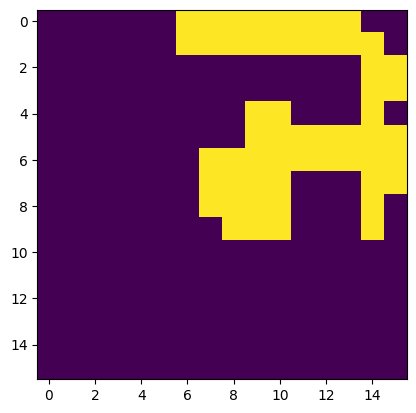

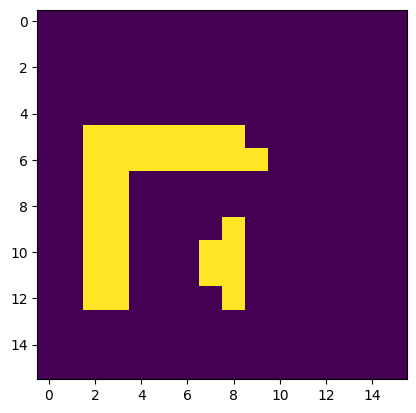

In [16]:
#Show samples
latent_vectors = np.random.normal(0.0, 1.0, [32, 16])
fake_images = generator.predict(latent_vectors)
#fake_images = np.rint(fake_images)
for i in range(32):
    plt.figure(i)
    plt.imshow(np.argmax(fake_images[i], axis=2))

plt.show()